### Importing libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import cv2
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

### Understanding the data

In [69]:
#Read text captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [70]:
captions = readTextFile("./Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [71]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [72]:
#Dictionary to map each image with the list of captions
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    image_name = first.split('.')[0]
    
    #if image name already present or not
    if descriptions.get(image_name) is None:
        descriptions[image_name] = []
    
    descriptions[image_name].append(second)

In [73]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

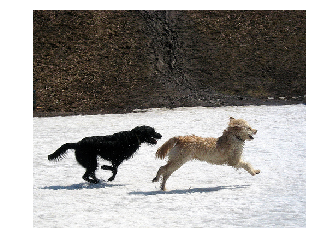

In [113]:
#Displaying the image
IMG_PATH = "Data/Images/"

img = cv2.imread(IMG_PATH + "2513260012_03d33305cf.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data cleaning

In [75]:
def clean_text(sentence):
    sentence = sentence.lower()
    senetence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()

    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [76]:
#Clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [77]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [78]:
#Writing data to text file
with open("descriptions.txt", "w") as f:
    f.write(str(descriptions))


### Creating a vocabulary

In [67]:
descriptions = None
with open("descriptions.txt", "r") as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [79]:
vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size: %d" %len(vocab))

Vocab Size: 8885


In [80]:
# Total number of words across all sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d" %len(total_words))

Total Words 373412


In [81]:
#Filter words from vocab according to certain threshold freq
import collections

counter = collections.Counter(total_words)
freq_count = dict(counter)
print(len(freq_count.keys()))

8885


In [82]:
#Sort dictionary according to freq count
sorted_freq_count = sorted(freq_count.items(), reverse=True, key=lambda x:x[1])

#Filter
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_count]

In [83]:
print(len(total_words))

1842


### Preparing Train/Test Data

In [84]:
train_file_data = readTextFile("./Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("./Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [85]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [86]:
#Prepare description for training data
# Add <s> and <e> token to our training data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for caption in descriptions[img_id]:
        cap_to_append = "<s> " + caption + " <e>"
        train_descriptions[img_id].append(cap_to_append)

In [118]:
train_descriptions["2513260012_03d33305cf"]

['<s> black dog is running after white dog in the snow <e>',
 '<s> black dog chasing brown dog through snow <e>',
 '<s> two dogs chase each other across the snowy ground <e>',
 '<s> two dogs play together in the snow <e>',
 '<s> two dogs running through low lying body of water <e>']

### Image Feature Extraction

In [47]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [48]:
model_new = Model(model.input, model.layers[-2].output)

In [88]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    img = preprocess_input(img)
    return img

In [89]:
# img = preprocess_img(IMG_PATH + "1000268201_693b08cb0e.jpg")
# plt.imshow(img[0])
# plt.axis("off")
# plt.show()

In [90]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [116]:
encode_image(IMG_PATH + "2513260012_03d33305cf.jpg")

array([0.28047287, 0.406874  , 0.08379952, ..., 0.91079146, 0.0434181 ,
       0.09577906], dtype=float32)

In [92]:
start_time = time()
encoding_train = {}

#image_id -> feature_vector extracted from ResnetImage
for ix, img_id in enumerate(train):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Encoding in progress Time step %d" %ix)

end_time = time()
print("Total time taken : ", end_time-start_time)

Encoding in progress Time step 0
Encoding in progress Time step 100
Encoding in progress Time step 200
Encoding in progress Time step 300
Encoding in progress Time step 400
Encoding in progress Time step 500
Encoding in progress Time step 600
Encoding in progress Time step 700
Encoding in progress Time step 800
Encoding in progress Time step 900
Encoding in progress Time step 1000
Encoding in progress Time step 1100
Encoding in progress Time step 1200
Encoding in progress Time step 1300
Encoding in progress Time step 1400
Encoding in progress Time step 1500
Encoding in progress Time step 1600
Encoding in progress Time step 1700
Encoding in progress Time step 1800
Encoding in progress Time step 1900
Encoding in progress Time step 2000
Encoding in progress Time step 2100
Encoding in progress Time step 2200
Encoding in progress Time step 2300
Encoding in progress Time step 2400
Encoding in progress Time step 2500
Encoding in progress Time step 2600
Encoding in progress Time step 2700
Enco

In [119]:
encoding_train["2513260012_03d33305cf"]

array([0.28047287, 0.406874  , 0.08379952, ..., 0.91079146, 0.0434181 ,
       0.09577906], dtype=float32)

In [120]:
#Store data to disk
with open("encoded_train_features.pkl", "wb") as f:
    pickle.dump(encoding_train, f)

In [121]:
start_time = time()
encoding_test = {}

#image_id -> feature_vector extracted from ResnetImage
for ix, img_id in enumerate(test):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Encoding in progress Time step %d" %ix)

end_time = time()
print("Total time taken : ", end_time-start_time)

Encoding in progress Time step 0
Encoding in progress Time step 100
Encoding in progress Time step 200
Encoding in progress Time step 300
Encoding in progress Time step 400
Encoding in progress Time step 500
Encoding in progress Time step 600
Encoding in progress Time step 700
Encoding in progress Time step 800
Encoding in progress Time step 900
Total time taken :  666.4716377258301


In [122]:
with open("encoded_test_features.pkl", "wb") as f:
    pickle.dump(encoding_test, f)

### Data pre-processing for captions

In [94]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [95]:
print(len(idx_to_word))

1842


In [96]:
#Adding start and end to dictionary
idx_to_word[1843] = "<s>"
word_to_idx["<s>"] = 1843

idx_to_word[1844] = "<e>"
word_to_idx["<e>"] = 1844

In [97]:
vocab_size = len(word_to_idx) + 1
print("Vocab size: ", vocab_size)

Vocab size:  1845


In [98]:
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))

print(max_len)

34


### Data Loader(Generator)

In [123]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X1, X2, y = [], [], []
    
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    X1, X2, y = [], [], []
                    n = 0

### Word Embeddings

In [26]:
f = open("./glove.6B.50d.txt", encoding='utf8')

In [27]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    
    embedding_index[word] = word_embedding

In [28]:
f.close()

In [29]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [30]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [31]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1845, 50)

In [32]:
embedding_matrix[1844]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model Architecture

In [103]:
#Image as input
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [104]:
#Caption as input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [105]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

#Combined Model
model = Model(inputs=[input_img_features, input_captions], outputs=outputs)

In [106]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 50)       92250       input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dropout_5 

In [107]:
#Pre-initialize the embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [108]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Training of model

In [109]:
# with open('encoded_train_features.pkl', 'rb') as f:
#     encoding_train = pickle.load(f)

In [110]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [124]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [125]:
train()

Epoch 1/1
2000/2000 [==============================] - 1010s 505ms/step - loss: 4.2891
Epoch 1/1
2000/2000 [==============================] - 1020s 510ms/step - loss: 3.5695
Epoch 1/1
2000/2000 [==============================] - 1016s 508ms/step - loss: 3.3122
Epoch 1/1
2000/2000 [==============================] - 822s 411ms/step - loss: 3.1575
Epoch 1/1
2000/2000 [==============================] - 758s 379ms/step - loss: 3.0470
Epoch 1/1
2000/2000 [==============================] - 704s 352ms/step - loss: 2.9644
Epoch 1/1
2000/2000 [==============================] - 746s 373ms/step - loss: 2.8985
Epoch 1/1
2000/2000 [==============================] - 887s 444ms/step - loss: 2.8445
Epoch 1/1
2000/2000 [==============================] - 815s 407ms/step - loss: 2.7992
Epoch 1/1
2000/2000 [==============================] - 766s 383ms/step - loss: 2.7595
Epoch 1/1
2000/2000 [==============================] - 804s 402ms/step - loss: 2.7270
Epoch 1/1
2000/2000 [==============================